In [1]:
import sys
sys.path.append('..')
from simtools import Strip, pattern_ascii

In [2]:
import matplotlib.pyplot as plt
import discretisedfield as df
import pandas as pd
import itertools
import numpy as np
from matplotlib.patches import ConnectionPatch
import micromagneticmodel as mm

This notebook contains a few long-running simulations. To speed up the notebook execution this data is pre-computed and stored in the repository in the `data` directory. To recompute all data in this notebook set the variable `recompute` in the next cell to `True`.

In [3]:
recompute = False

In [4]:
datapath = '../data/'  # comment this line and uncomment the following line to use new data created with
# datapath = 'data/'   # the `create_data.ipynb` notebook in this directory

In [5]:
# taken from: https://jfly.uni-koeln.de/color/
colors = [[0.        , 0.        , 0.        ],
          [0.90196078, 0.62352941, 0.        ],
          [0.3372549 , 0.70588235, 0.91372549],
          [0.        , 0.61960784, 0.45098039],
          [0.8       , 0.4745098 , 0.65490196],
          [0.        , 0.44705882, 0.69803922],
          [0.83529412, 0.36862745, 0.        ],
          [0.94117647, 0.89411765, 0.25882353]]

# 80 Bloch points

## Minimisation

In [6]:
if recompute:
    pattern = pattern_ascii('Blochpoint')
    strip_Blochpoint = Strip(
        length=165e-9*len(pattern),
        width=100e-9,
        htop=10e-9,
        hbottom=20e-9,
        dirname='data',
        initpattern=pattern,
        cell=(2.5e-9, 2.5e-9, 2.5e-9))

    strip_Blochpoint.min_drive(fixed=True)
    strip_Blochpoint.min_drive()
    strip_Blochpoint.count_bp_and_save('initial')

    field = df.Field(strip_Blochpoint.system.m.mesh, dim=3, value=strip_Blochpoint.system.m.array.copy())
else:
    field = df.Field.fromfile(f'{datapath}/80BP/0_initial.hdf5')

# Field pulse

In [7]:
if recompute:
    # field pulse
    H = (0, 0.25 / mm.consts.mu0, 0)
    strip_Blochpoint.system.energy += mm.Zeeman(H=H)
    strip_Blochpoint.time_drive(t=.5e-9, n=50)
    strip_Blochpoint.count_bp_and_save('field')
    field_pulse = df.Field(strip_Blochpoint.system.m.mesh, dim=3, value=strip_Blochpoint.system.m.array.copy())

    # free relaxation
    strip_Blochpoint.system.energy -= mm.Zeeman(H=H)
    strip_Blochpoint.time_drive(t=5e-9, n=500)
    strip_Blochpoint.count_bp_and_save('relaxation')
    field_relaxation = df.Field(strip_Blochpoint.system.m.mesh, dim=3, value=strip_Blochpoint.system.m.array.copy())
else:
    field_pulse = df.Field.fromfile(f'{datapath}/80BP/1_fieldpulse.hdf5')
    field_relaxation = df.Field.fromfile(f'{datapath}/80BP/2_relaxation.hdf5')

# Optimal geometry

In [8]:
def one_pattern(dataset, accuracy, pmin, pmax):
    x = dataset['length'].to_numpy()
    y = dataset['E_density'].to_numpy()
    
    lengths = []
    energies = []
    n_typechanges = []
    poly_order = []
    n_left = []
    n_right = []

    # Fit polynomial to different numbers of points and use the median value as optimal length l_o.
    # Reason: the correct mathematical form is not known and estimating the error of the fit
    # is difficult as it is not generally clear how many points around the minimum to take into account.
    for l, r in itertools.product(range(6, 20), range(6, 20)):
        x0 = x[np.argmin(y)]
        x2 = x[max(np.argmin(y) - l, 0): min(np.argmin(y) + r, len(y))]
        y2 = y[max(np.argmin(y) - l, 0): min(np.argmin(y) + r, len(y))]
        for degree in range(pmin, pmax + 1):
            if len(x2) <= degree:
                continue
            poly = np.polynomial.Polynomial.fit(x2, y2, degree)
            # Filter out minima of the polynomial that do not lie close to the estimated minimum point x0.
            # It can happen that the fit has a wrong minimum far away from the estimated value (estimate based on the simulation points).
            for root in poly.deriv().roots():
                if root.imag == 0 and abs(root.real - x0) < accuracy:
                    n_left.append(l)
                    n_right.append(r)
                    poly_order.append(degree)
                    lengths.append(root.real)
                    energies.append(poly(root.real))
                    
    min_data = pd.DataFrame(dict(length=lengths, energy=energies, order=poly_order, nl=n_left, nr=n_right))
    min_data = min_data[(min_data['length'] > 0) & (min_data['length'] < 1e4)]
    
    # statistics of the fits
    m = min_data.groupby('order').median()[['length', 'energy']]
    s = min_data.groupby('order').std()[['length', 'energy']]
    return m.join(s, lsuffix='_median', rsuffix='_std')

In [9]:
def one_width(dataset, pmin=5, pmax=5, accuracy=50):
    base_p = 'io'*10
    res = pd.DataFrame()
    for number, group in dataset.groupby(['bp_number']):
        subres = one_pattern(group.loc[group['initpattern'] == base_p[:int(number)]], pmin=pmin, pmax=pmax, accuracy=accuracy)
        subres['bp_number'] = int(number)
        subres['order'] = subres.index
        res = pd.concat([res, subres])
    res.reindex()
    res['width'] = dataset['width'].unique()[0]
    return res

In [10]:
all_data = pd.read_csv(f'{datapath}figure5.csv')
all_data = all_data.loc[all_data['expected_config']]
all_data = all_data.loc[all_data['y_centred']]

## $l_{\mathrm{o}}$

In [11]:
lo = []

for w, max_ in zip([100, 150, 200],
                   [8, 8, 7]):  # restrict maximum number of Bloch points used in the fit because the number changes with the strip width
    res = one_width(all_data[(all_data['width'] == w) & (all_data['bp_number'] > 1) & (all_data['bp_number'] < 9)])
    poly = np.polynomial.Polynomial.fit(res.loc[res['bp_number'].isin(range(max_))]['bp_number'], res.loc[res['bp_number'].isin(range(max_))]['length_median'], 1)
    lo.append([res, poly])

# $s_{\mathrm{o}}$

In [12]:
so_widths = []
so = []

for width in range(100, 201, 20):
    data = all_data[(all_data['width'] == width) & (all_data['bp_number'] > 1) & (all_data['bp_number'] < 9)]
    lengths = one_width(data)
    poly = np.polynomial.Polynomial.fit(lengths['bp_number'], lengths['length_median'], 1)
    so.append(poly(1) - poly(0))
    so_widths.append(width)

# Figure

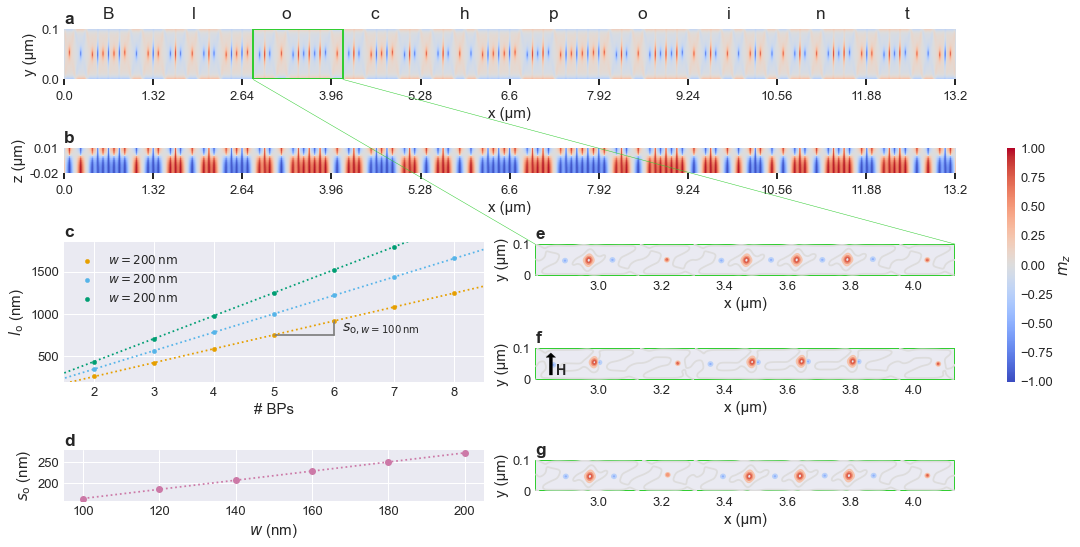

In [13]:
layout = '''
         zz.
         yyc
         sic
         sec
         tf.
         '''
cmap = 'coolwarm'
fig, axs = plt.subplot_mosaic(layout, figsize=(15, 7.7), gridspec_kw={'width_ratios': [50, 50, 1], 'height_ratios': [1, .5, .7, .7, 1,]})
field.plane(z=5e-9).orientation.z.mpl.scalar(ax=axs['z'], clim=(-1, 1), aspect='auto', cmap=cmap, colorbar=False)
field.plane('y').orientation.z.mpl.scalar(ax=axs['y'], clim=(-1, 1), aspect='auto', cmap=cmap, colorbar=False)
fig.colorbar(axs['z'].images[0], cax=axs['c'], label=r'$m_z$')

for ax in [axs['y'], axs['z']]:
    ax.set_xticks([i * 8 * 165e-3 for i in range(11)])
    ax.set_xticklabels([round(i * 8 * 165e-3, 2) for i in range(11)])
    ax.tick_params(axis='x', direction='out', length=6, width=2)
    ax.set_xlabel('x (μm)')
axs['z'].set_ylabel('y (μm)')
axs['y'].set_ylabel('z (μm)')
axs['y'].set_yticks([-0.02, 0.01])
axs['y'].set_yticklabels([-0.02, 0.01])
axs['z'].add_patch(plt.Rectangle((2.8, 0), 4.13-2.8, 0.1, facecolor='none', edgecolor='limegreen', lw=2))

sel_region = df.Region(p1=(2800e-9, 0, -20e-9), p2=(4130e-9, 100e-9, 10e-9))
field[sel_region].plane(z=1e-9).orientation.z.mpl.contour(colorbar=False, cmap=cmap, ax=axs['i'])
field_pulse[sel_region].plane(z=1e-9).orientation.z.mpl.contour(colorbar=False, cmap=cmap, ax=axs['e'])
field_relaxation[sel_region].plane(z=1e-9).orientation.z.mpl.contour(colorbar=False, cmap=cmap, ax=axs['f'])

for ax in [axs['i'], axs['e'], axs['f']]:
    ax.set_yticks([0, 0.1])
    ax.set_yticklabels([0, 0.1])
    ax.set_xlabel('x (μm)')
    ax.set_ylabel('y (μm)')

for c in ['i', 'e', 'f']:
    axs[c].add_patch(plt.Rectangle((2.8, 0), 4.13-2.8, 0.1, facecolor='none', edgecolor='limegreen', lw=2))
    
axs['e'].add_patch(plt.Arrow(x=2.85, y=0.015, dx=0, dy=0.07, width=0.05, color='k', zorder=2))
axs['e'].annotate('H', xy=(2.85, 0.015), xycoords='data', xytext=(5, 0), textcoords='offset points', fontsize='x-large', fontweight='bold')

for p, c in zip(['z', 'y', 's', 't', 'i', 'e', 'f'],
                ['a', 'b', 'c', 'd', 'e', 'f', 'g']):
    axs[p].annotate(c, xy=(0, 1), xycoords='axes fraction', xytext=(0, 5), textcoords='offset points', fontweight='bold', fontsize='xx-large')

for x in [2.8, 4.13]:
    con = ConnectionPatch(xyA=(x, 0), coordsA=axs['z'].transData, xyB=(x, 0.1), coordsB=axs['i'].transData)
    con.set(linewidth=.5, color='limegreen')
    fig.add_artist(con)

for i, c in enumerate('Blochpoint'):
    axs['z'].annotate(c, xy=((i*8 + 3.5) * 0.165 , 0.1), xycoords='data', xytext=(0, 10), textcoords='offset points', fontsize='xx-large')

for i, ((res, poly), c) in enumerate(zip(lo, colors[1:])):
    res.plot.scatter(x='bp_number', y='length_median', ax=axs['s'], color=[c], label=fr'$w = {w}\,\mathrm{{nm}}$')
    if i == 0:
        x1, x2 = 5, 6
        axs['s'].plot([x1, x2], [poly(x1), poly(x1)], c='grey')
        axs['s'].plot([x2, x2], [poly(x1), poly(x2)], c='grey')
        axs['s'].annotate(r'$s_{\mathrm{o}, w=100\,\mathrm{nm}}$', xy=(x2, poly(5)), xycoords='data', xytext=(8, 3), textcoords='offset points', fontsize='x-large')
    xx = np.linspace(1, 9, 100)
    axs['s'].plot(xx, poly(xx), ':', color=c)
axs['s'].legend()
axs['s'].set_xlabel('# BPs')
axs['s'].set_ylabel(r'$l_{\mathrm{o}}$ (nm)')
    
axs['s'].set_ylim((200, 1850))
axs['s'].set_xlim((1.5, 8.5))
axs['s'].grid()

axs['t'].plot(so_widths, so, 'o', color=colors[4])
axs['t'].plot(np.linspace(100, 200, 100), np.polynomial.Polynomial.fit(so_widths, so, 1)(np.linspace(100, 200, 100)), ':', color=colors[4])
axs['t'].set_xlabel(r'$w$ (nm)')
axs['t'].set_ylabel(r'$s_{\mathrm{o}}$ (nm)')
axs['t'].grid()

fig.tight_layout()